In [65]:
!pip install nlp


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.13.0


In [110]:
import pandas as pd


In [111]:
!pip install datasets


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [112]:
from datasets import load_dataset
from datasets import list_datasets
all_datasets = list_datasets()

In [113]:
emotions = load_dataset('emotion')

In [114]:
train = emotions['train']
test = emotions['test']
val =emotions['validation']

In [115]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [117]:
tweet, label = get_tweet(train)
val_tweet, val_label = get_tweet(val)

In [79]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [119]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweet)
tokenizer.fit_on_texts(val_tweet)

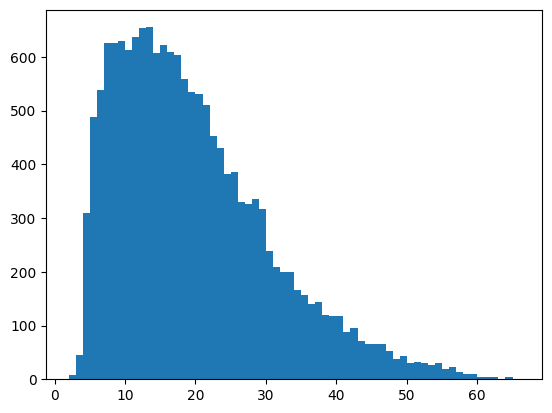

In [120]:
lengths = [len(t.split(' ')) for t in tweet]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [121]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [122]:
def get_sequences(tokenizer, tweet):
    sequences = tokenizer.texts_to_sequences(tweet)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [124]:
padded_train_seq = get_sequences(tokenizer, tweet)
val_seq = get_sequences(tokenizer, val_tweet)

In [125]:
classes = set(label)
print(classes)

{0, 1, 2, 3, 4, 5}


In [126]:
classes = emotions['train'].features['label'].names

In [163]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df_val = emotions['validation'][:]

In [164]:
df['label_name'] = df['label'].apply(lambda x: classes[x])
df_val['label_name'] = df_val['label'].apply(lambda x: classes[x])

In [129]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [130]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')    
])

model.compile(
    
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [136]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


('i didnt feel humiliated', 0)

In [137]:
padded_train_seq = np.asarray(padded_train_seq)
label = np.asarray(label)
val_seq = np.asarray(val_seq)
val_label = np.asarray(val_label)

In [138]:
h = model.fit(
    padded_train_seq, label,
    validation_data=(val_seq, val_label),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 18s 21ms/step - loss: 1.3535 - accuracy: 0.4694 - val_loss: 0.9387 - val_accuracy: 0.6715
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.6051 - accuracy: 0.7989 - val_loss: 0.4935 - val_accuracy: 0.8425
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2953 - accuracy: 0.9061 - val_loss: 0.4443 - val_accuracy: 0.8660
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1825 - accuracy: 0.9437 - val_loss: 0.3656 - val_accuracy: 0.8915
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1422 - accuracy: 0.9542 - val_loss: 0.3650 - val_accuracy: 0.8865
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1100 - accuracy: 0.9648 - val_loss: 0.3812 - val_accuracy: 0.8915


In [190]:
i = random.randint(0, len(val_label) - 1)

print('Sentence: ', val_tweet[i])
print('Emotion: ', df_val['label_name'][i])

p = model.predict(np.expand_dims(val_seq[i], axis=0))[0]
pred_class = np.argmax(p)

print('Predicted Emotion: ', classes[pred_class])

Sentence:  i have a feeling this will be a lovely little thing of a perfume
Emotion:  love
1/1 [==============================] - 0s 32ms/step
Predicted Emotion:  love


In [192]:
predictions = np.argmax(model.predict(val_seq),axis=1)

63/63 [==============================] - 1s 10ms/step


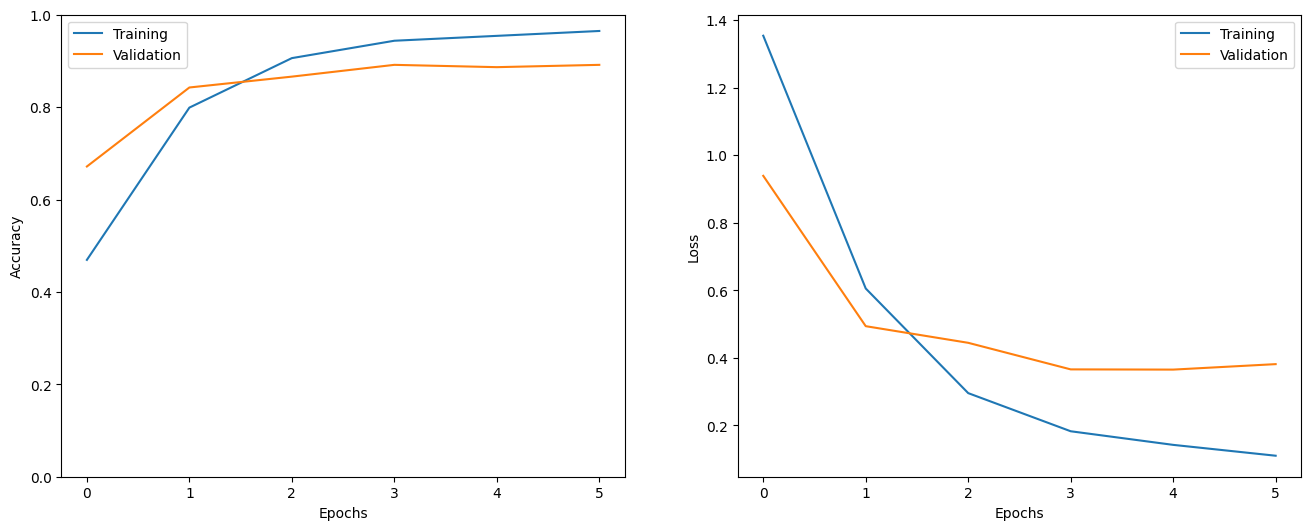

In [194]:
show_history(h)

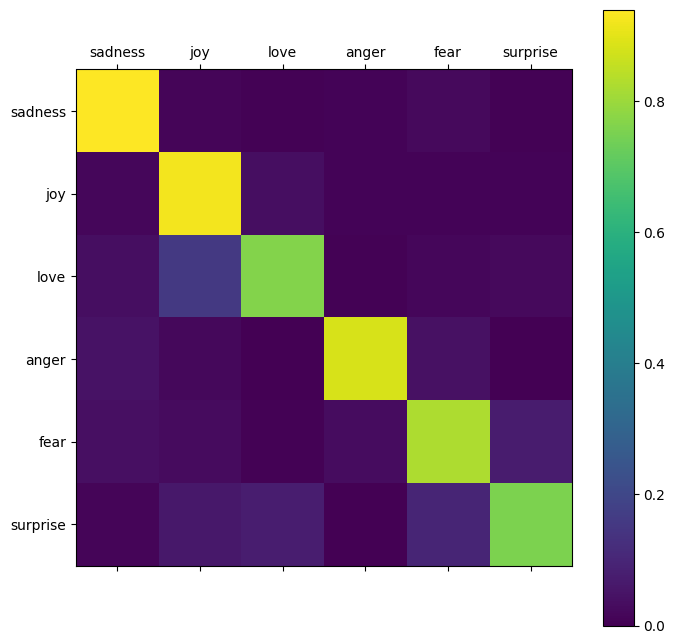

In [193]:
show_confusion_matrix(val_label, predictions, list(classes))